# 

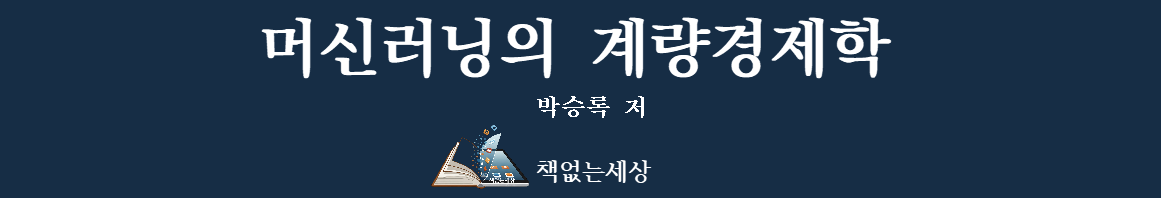

# Part 8: 인과추론

## Chapter 3. 방향성 비순환 그래프를 활용한 인과추론

#### 예제 1: networkx를 이용한 DAG 그리기

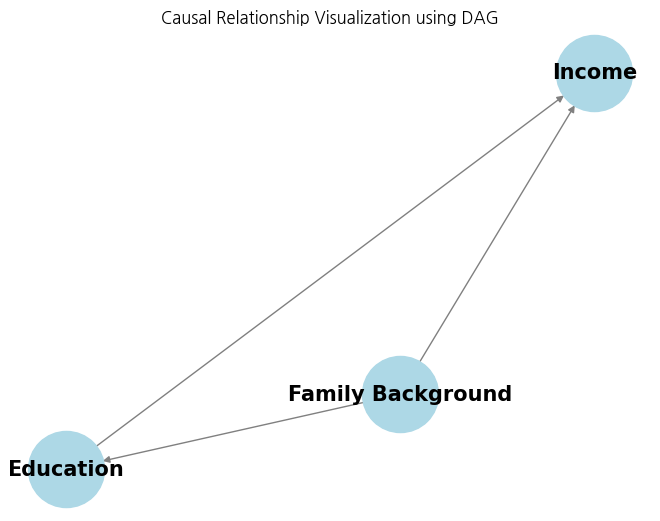

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# DAG 생성
dag = nx.DiGraph()

# 노드 정의
dag.add_nodes_from(["Education", "Income", "Family Background"])

# 인과관계를 나타내는 에지
dag.add_edges_from([
    ("Family Background", "Education"),
    ("Family Background", "Income"),
    ("Education", "Income")
                   ])

# DAG의 시각화
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=15, font_weight='bold')
plt.title("Causal Relationship Visualization using DAG")
plt.show()

#### 예제 2: DoWhy를 이용한 인과추론

In [22]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np

# 표본자료의 생성(sample data)
np.random.seed(42)
data = pd.DataFrame({
    'Family_Background': np.random.normal(0, 1, 1000),
    'Education': np.random.normal(0, 1, 1000),
    'Income': np.random.normal(0, 1, 1000)
                    })

# 변수들의 인과관계 정의(여기서 Family Background는 교란변수)
data['Education'] += 0.5 * data['Family_Background'] + np.random.normal(0, 0.1, 1000)
data['Income'] += 0.7 * data['Education'] + 0.3 * data['Family_Background'] + np.random.normal(0, 0.1, 1000)

# 인과모형 설정
model = CausalModel(
    data=data,
    treatment='Education',
    outcome='Income',
    common_causes=['Family_Background']
                    )

In [23]:
# 인과효과의 식별
identified_model = model.identify_effect()
print(identified_model)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[Income|Family_Background])
d[Education]                             
Estimand assumption 1, Unconfoundedness: If U→{Education} and U→Income then P(Income|Education,Family_Background,U) = P(Income|Education,Family_Background)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
     d                                   
────────────(E[Income|Family_Background])
d[Education]                             
Estimand assumption 1, Unconfoundedness: If U→{Education} and U→Income then P(Income|Education,Family_Background,U) = P(Income|Education,Family_Background)



In [24]:
# 인과효과 모형의 추정
estimate = model.estimate_effect(identified_model, method_name="backdoor.linear_regression")
print("Estimated causal effect of Education on Income:", estimate.value)

Estimated causal effect of Education on Income: 0.6902451507875083


In [25]:
# 추정결과의 반증(placebo_treatment_refuter 활용)
refutation = model.refute_estimate(
    identified_model, estimate, 
    "placebo_treatment_refuter"
                                  )
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:0.6902451507875083
New effect:0.0
p value:1.0



In [26]:
refutation = model.refute_estimate(
    identified_model, estimate, 
    "random_common_cause"
                                   )
print(refutation)

refutation = model.refute_estimate(
    identified_model, estimate, 
    "data_subset_refuter"
                                  )
print(refutation)

Refute: Add a random common cause
Estimated effect:0.6902451507875083
New effect:0.6902766970794347
p value:0.96

Refute: Use a subset of data
Estimated effect:0.6902451507875083
New effect:0.6917808271017034
p value:0.96

